# Notebook 01: Data Loading, Validation, and Cleaning

---

## Executive Summary

This notebook serves as the foundational step in our Customer Lifetime Value (CLV) prediction pipeline. Before any sophisticated modeling can take place, we must ensure our data is **clean, consistent, and well-understood**. Think of this as the "pre-flight checklist" before launching a rocket—every sensor must be verified, every system calibrated.

### What This Notebook Covers:

1. **Project Context & Business Problem** — Understanding *why* we're doing this analysis
2. **Data Ingestion** — Loading the raw dataset with proper validation
3. **Schema Inspection** — Understanding data types, column semantics, and structure
4. **Data Quality Assessment** — Detecting missing values, duplicates, and anomalies
5. **Data Cleaning Pipeline** — Standardizing strings, fixing dates, and preparing data for analysis
6. **Quality Assurance Checkpoint** — Saving a verified, clean dataset for downstream use

---

## 1. Project Context and Business Problem

### 1.1 The Business Challenge

In the fiercely competitive automobile insurance industry, understanding the **long-term value of each customer** is not just useful—it's essential for survival. Companies that can accurately predict which customers will generate the most revenue over their lifetime can:

- **Optimize Acquisition Budgets**: Spend more to acquire high-value customers, less on low-value ones
- **Improve Retention Strategies**: Focus retention efforts on customers who are worth keeping
- **Personalize Product Offerings**: Tailor coverage packages to specific value segments
- **Forecast Revenue**: Accurately project future income based on current customer base

### 1.2 The Dataset

We are working with the **Watson Analytics Marketing Customer Value Analysis** dataset, which contains detailed records of automobile insurance customers. This dataset is particularly valuable because it includes:

| Category | Information Available |
|----------|----------------------|
| **Demographics** | State, Gender, Education, Marital Status, Income |
| **Policy Details** | Coverage Level, Policy Type, Monthly Premium, Renewal Offers |
| **Behavioral Data** | Number of Policies, Open Complaints, Claims History |
| **Target Variable** | Customer Lifetime Value (CLV) in dollars |

### 1.3 Research Questions

Before diving into the data, let's articulate the questions we aim to answer:

1. **Primary Question**: Can we accurately predict Customer Lifetime Value using demographic and policy information?
2. **Secondary Questions**:
   - Which features are the strongest predictors of CLV?
   - Are there distinct customer segments with different value profiles?
   - What actionable insights can we derive for marketing strategy?

---

## 2. Environment Setup and Library Imports

We begin by importing all necessary libraries. This section serves as a **manifest of our technical dependencies**—critical for reproducibility.

### Why These Libraries?

| Library | Purpose | Version Used |
|---------|---------|-------------|
| `pandas` | Data manipulation and analysis | >= 1.5.0 |
| `numpy` | Numerical computing | >= 1.21.0 |
| `matplotlib` | Static visualizations | >= 3.5.0 |
| `seaborn` | Statistical visualizations | >= 0.12.0 |
| `os` | File system operations | Built-in |

In [23]:
# ============================================================================
# ENVIRONMENT SETUP
# ============================================================================

# Core Data Libraries
import pandas as pd
import numpy as np

# Visualization Libraries
import matplotlib.pyplot as plt
import seaborn as sns

# System Libraries
import os
import warnings
from datetime import datetime

# Display Settings
pd.set_option('display.max_columns', None)  # Show all columns
pd.set_option('display.max_rows', 100)       # Limit row display
pd.set_option('display.float_format', '{:.2f}'.format)  # Format floats

# Visualization Settings
plt.style.use('seaborn-v0_8-whitegrid')  # Clean, professional style
sns.set_palette('viridis')                # Colorblind-friendly palette
plt.rcParams['figure.figsize'] = (12, 6)  # Default figure size
plt.rcParams['font.size'] = 11            # Readable font size

# Suppress Warnings (for clean output)
warnings.filterwarnings('ignore')

# Print Environment Info
print("=" * 60)
print("ENVIRONMENT CONFIGURATION")
print("=" * 60)
print(f"Pandas Version:     {pd.__version__}")
print(f"NumPy Version:      {np.__version__}")
print(f"Execution Time:     {datetime.now().strftime('%Y-%m-%d %H:%M:%S')}")
print("=" * 60)

ENVIRONMENT CONFIGURATION
Pandas Version:     2.1.4
NumPy Version:      1.26.3
Execution Time:     2026-02-01 02:12:32


## 3. Configuration and Path Management

Centralizing all file paths and configuration parameters in one place is a **best practice** that makes the code:
- Easier to maintain (change once, apply everywhere)
- More portable (adapt paths for different environments)
- Self-documenting (all settings visible in one location)

In [24]:
# ============================================================================
# CONFIGURATION
# ============================================================================

# Define Base Paths
BASE_DIR = os.path.dirname(os.getcwd())  # Parent of notebooks folder
DATA_RAW_DIR = os.path.join(BASE_DIR, 'data', 'raw')
DATA_PROCESSED_DIR = os.path.join(BASE_DIR, 'data', 'processed')
FIGURES_DIR = os.path.join(BASE_DIR, 'report', 'figures')

# Source Data File
DATA_FILE = 'WA_Fn-UseC_-Marketing-Customer-Value-Analysis.csv'
DATA_PATH = os.path.join(DATA_RAW_DIR, DATA_FILE)

# Output Files
CLEAN_DATA_PATH = os.path.join(DATA_PROCESSED_DIR, 'cleaned_data.csv')
BACKUP_PATH = os.path.join(DATA_PROCESSED_DIR, 'raw_backup.csv')

# Create directories if they don't exist
for directory in [DATA_RAW_DIR, DATA_PROCESSED_DIR, FIGURES_DIR]:
    os.makedirs(directory, exist_ok=True)

# Verify Configuration
print("=" * 60)
print("PATH CONFIGURATION")
print("=" * 60)
print(f"Base Directory:        {BASE_DIR}")
print(f"Raw Data Directory:    {DATA_RAW_DIR}")
print(f"Processed Data Dir:    {DATA_PROCESSED_DIR}")
print(f"Figures Directory:     {FIGURES_DIR}")
print(f"Source Data File:      {DATA_PATH}")
print(f"\nFile Exists: {os.path.exists(DATA_PATH)}")
print("=" * 60)

PATH CONFIGURATION
Base Directory:        d:\antigravity project\WA_Fn-UseC_-Marketing-Customer-Value-Analysis.csv\CLV_IEEE_Project
Raw Data Directory:    d:\antigravity project\WA_Fn-UseC_-Marketing-Customer-Value-Analysis.csv\CLV_IEEE_Project\data\raw
Processed Data Dir:    d:\antigravity project\WA_Fn-UseC_-Marketing-Customer-Value-Analysis.csv\CLV_IEEE_Project\data\processed
Figures Directory:     d:\antigravity project\WA_Fn-UseC_-Marketing-Customer-Value-Analysis.csv\CLV_IEEE_Project\report\figures
Source Data File:      d:\antigravity project\WA_Fn-UseC_-Marketing-Customer-Value-Analysis.csv\CLV_IEEE_Project\data\raw\WA_Fn-UseC_-Marketing-Customer-Value-Analysis.csv

File Exists: True


---

## 4. Data Loading with Validation

Loading data might seem trivial, but proper validation at this stage prevents countless headaches later. We implement a **defensive loading strategy** that:

1. Verifies file existence before attempting to read
2. Reports file metadata (size, modification date)
3. Captures the raw state before any transformations
4. Provides immediate feedback on data dimensions

### Why This Matters in Practice

In production environments, data files can:
- Be corrupted during transfer
- Have schema changes from upstream systems
- Arrive empty or partially written

Validating early catches these issues before they cascade into mysterious errors downstream.

In [25]:
# ============================================================================
# DATA LOADING WITH VALIDATION
# ============================================================================

def load_data_with_validation(filepath):
    """
    Load CSV data with comprehensive validation.
    
    Parameters:
    -----------
    filepath : str
        Path to the CSV file
        
    Returns:
    --------
    pd.DataFrame
        Loaded dataframe
        
    Raises:
    -------
    FileNotFoundError
        If the file doesn't exist
    ValueError
        If the file is empty
    """
    
    # Step 1: Verify file exists
    if not os.path.exists(filepath):
        raise FileNotFoundError(f"Data file not found: {filepath}")
    
    # Step 2: Get file metadata
    file_size = os.path.getsize(filepath)
    file_modified = datetime.fromtimestamp(os.path.getmtime(filepath))
    
    print(f"📁 Loading: {os.path.basename(filepath)}")
    print(f"   Size: {file_size / 1024:.2f} KB ({file_size / (1024*1024):.2f} MB)")
    print(f"   Last Modified: {file_modified.strftime('%Y-%m-%d %H:%M:%S')}")
    
    # Step 3: Load the data
    df = pd.read_csv(filepath)
    
    # Step 4: Basic validation
    if df.empty:
        raise ValueError("Loaded DataFrame is empty!")
    
    # Step 5: Report dimensions
    print(f"\n✅ Successfully loaded {len(df):,} rows × {len(df.columns)} columns")
    
    return df

# Load the data
df_raw = load_data_with_validation(DATA_PATH)

📁 Loading: WA_Fn-UseC_-Marketing-Customer-Value-Analysis.csv
   Size: 1535.92 KB (1.50 MB)
   Last Modified: 2026-02-01 01:19:47

✅ Successfully loaded 9,134 rows × 24 columns


### 4.1 First Look at the Raw Data

The `.head()` method shows us the first few rows. This is our **initial reconnaissance**—what does the data actually look like?

Pay attention to:
- Column naming conventions (spacing, capitalization)
- Apparent data types (numbers, text, dates)
- Any obvious formatting issues

In [26]:
# Display first 5 rows
print("=" * 80)
print("FIRST 5 ROWS OF RAW DATA")
print("=" * 80)
df_raw.head()

FIRST 5 ROWS OF RAW DATA


,Customer,State,Customer Lifetime Value,Response,Coverage,Education,Effective To Date,EmploymentStatus,Gender,Income,Location Code,Marital Status,Monthly Premium Auto,Months Since Last Claim,Months Since Policy Inception,Number of Open Complaints,Number of Policies,Policy Type,Policy,Renew Offer Type,Sales Channel,Total Claim Amount,Vehicle Class,Vehicle Size
0,BU79786,Washington,2763.52,No,Basic,Bachelor,2/24/11,Employed,F,56274,Suburban,Married,69,32,5,0,1,Corporate Auto,Corporate L3,Offer1,Agent,384.81,Two-Door Car,Medsize
1,QZ44356,Arizona,6979.54,No,Extended,Bachelor,1/31/11,Unemployed,F,0,Suburban,Single,94,13,42,0,8,Personal Auto,Personal L3,Offer3,Agent,1131.46,Four-Door Car,Medsize
2,AI49188,Nevada,12887.43,No,Premium,Bachelor,2/19/11,Employed,F,48767,Suburban,Married,108,18,38,0,2,Personal Auto,Personal L3,Offer1,Agent,566.47,Two-Door Car,Medsize
3,WW63253,California,7645.86,No,Basic,Bachelor,1/20/11,Unemployed,M,0,Suburban,Married,106,18,65,0,7,Corporate Auto,Corporate L2,Offer1,Call Center,529.88,SUV,Medsize
4,HB64268,Washington,2813.69,No,Basic,Bachelor,2/3/11,Employed,M,43836,Rural,Single,73,12,44,0,1,Personal Auto,Personal L1,Offer1,Agent,138.13,Four-Door Car,Medsize


In [27]:
# Display last 5 rows (to check for truncation issues)
print("=" * 80)
print("LAST 5 ROWS OF RAW DATA (Checking for truncation)")
print("=" * 80)
df_raw.tail()

LAST 5 ROWS OF RAW DATA (Checking for truncation)


,Customer,State,Customer Lifetime Value,Response,Coverage,Education,Effective To Date,EmploymentStatus,Gender,Income,Location Code,Marital Status,Monthly Premium Auto,Months Since Last Claim,Months Since Policy Inception,Number of Open Complaints,Number of Policies,Policy Type,Policy,Renew Offer Type,Sales Channel,Total Claim Amount,Vehicle Class,Vehicle Size
9129,LA72316,California,23405.99,No,Basic,Bachelor,2/10/11,Employed,M,71941,Urban,Married,73,18,89,0,2,Personal Auto,Personal L1,Offer2,Web,198.23,Four-Door Car,Medsize
9130,PK87824,California,3096.51,Yes,Extended,College,2/12/11,Employed,F,21604,Suburban,Divorced,79,14,28,0,1,Corporate Auto,Corporate L3,Offer1,Branch,379.20,Four-Door Car,Medsize
9131,TD14365,California,8163.89,No,Extended,Bachelor,2/6/11,Unemployed,M,0,Suburban,Single,85,9,37,3,2,Corporate Auto,Corporate L2,Offer1,Branch,790.78,Four-Door Car,Medsize
9132,UP19263,California,7524.44,No,Extended,College,2/3/11,Employed,M,21941,Suburban,Married,96,34,3,0,3,Personal Auto,Personal L2,Offer3,Branch,691.20,Four-Door Car,Large
9133,Y167826,California,2611.84,No,Extended,College,2/14/11,Unemployed,M,0,Suburban,Single,77,3,90,0,1,Corporate Auto,Corporate L3,Offer4,Call Center,369.60,Two-Door Car,Medsize


---

## 5. Schema Inspection and Data Profiling

Understanding the **schema** (structure) of our data is critical. We need to know:

1. **What columns exist?** — The feature set available to us
2. **What are their data types?** — Determines valid operations
3. **Are there missing values?** — Impacts analysis strategies
4. **What are the value ranges?** — Helps identify anomalies

### 5.1 DataFrame Info (Technical Schema)

In [28]:
# Comprehensive schema information
print("=" * 80)
print("DATAFRAME SCHEMA INFORMATION")
print("=" * 80)
df_raw.info()

DATAFRAME SCHEMA INFORMATION
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9134 entries, 0 to 9133
Data columns (total 24 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   Customer                       9134 non-null   object 
 1   State                          9134 non-null   object 
 2   Customer Lifetime Value        9134 non-null   float64
 3   Response                       9134 non-null   object 
 4   Coverage                       9134 non-null   object 
 5   Education                      9134 non-null   object 
 6   Effective To Date              9134 non-null   object 
 7   EmploymentStatus               9134 non-null   object 
 8   Gender                         9134 non-null   object 
 9   Income                         9134 non-null   int64  
 10  Location Code                  9134 non-null   object 
 11  Marital Status                 9134 non-null   object 
 12  Monthly Premium Aut

### 5.2 Column Inventory

Let's create a detailed inventory of all columns with their inferred purposes.

In [29]:
# Column inventory with data types and sample values
def create_column_inventory(df):
    """
    Create a detailed inventory of DataFrame columns.
    """
    inventory = []
    
    for col in df.columns:
        inventory.append({
            'Column': col,
            'Data Type': str(df[col].dtype),
            'Non-Null Count': df[col].notna().sum(),
            'Null Count': df[col].isna().sum(),
            'Null %': f"{(df[col].isna().sum() / len(df) * 100):.1f}%",
            'Unique Values': df[col].nunique(),
            'Sample Value': str(df[col].dropna().iloc[0]) if len(df[col].dropna()) > 0 else 'N/A'
        })
    
    return pd.DataFrame(inventory)

column_inventory = create_column_inventory(df_raw)
print("=" * 100)
print("COMPLETE COLUMN INVENTORY")
print("=" * 100)
column_inventory

COMPLETE COLUMN INVENTORY


,Column,Data Type,Non-Null Count,Null Count,Null %,Unique Values,Sample Value
0,Customer,object,9134,0,0.0%,9134,BU79786
1,State,object,9134,0,0.0%,5,Washington
2,Customer Lifetime Value,float64,9134,0,0.0%,8041,2763.519279
3,Response,object,9134,0,0.0%,2,No
4,Coverage,object,9134,0,0.0%,3,Basic
5,Education,object,9134,0,0.0%,5,Bachelor
6,Effective To Date,object,9134,0,0.0%,59,2/24/11
7,EmploymentStatus,object,9134,0,0.0%,5,Employed
8,Gender,object,9134,0,0.0%,2,F
9,Income,int64,9134,0,0.0%,5694,56274


### 5.3 Descriptive Statistics for Numerical Features

The `.describe()` method provides the **five-number summary** plus mean and standard deviation. This helps us understand the **central tendency** and **spread** of numerical data.

**Key Statistics to Examine:**
- **Mean vs Median (50%)**: Large differences suggest skewness
- **Std (Standard Deviation)**: Measures spread; high std = high variability
- **Min/Max**: Extreme values may indicate outliers or data errors

In [30]:
# Descriptive statistics for numerical columns
print("=" * 100)
print("DESCRIPTIVE STATISTICS (NUMERICAL FEATURES)")
print("=" * 100)
df_raw.describe().T.round(2)  # Transposed for better readability

DESCRIPTIVE STATISTICS (NUMERICAL FEATURES)


,count,mean,std,min,25%,50%,75%,max
Customer Lifetime Value,9134.00,8004.94,6870.97,1898.01,3994.25,5780.18,8962.17,83325.38
Income,9134.00,37657.38,30379.90,0.00,0.00,33889.50,62320.00,99981.00
Monthly Premium Auto,9134.00,93.22,34.41,61.00,68.00,83.00,109.00,298.00
Months Since Last Claim,9134.00,15.10,10.07,0.00,6.00,14.00,23.00,35.00
Months Since Policy Inception,9134.00,48.06,27.91,0.00,24.00,48.00,71.00,99.00
Number of Open Complaints,9134.00,0.38,0.91,0.00,0.00,0.00,0.00,5.00
Number of Policies,9134.00,2.97,2.39,1.00,1.00,2.00,4.00,9.00
Total Claim Amount,9134.00,434.09,290.50,0.10,272.26,383.95,547.51,2893.24


### 5.4 Categorical Feature Overview

For categorical (text) columns, we need to understand:
- How many unique categories exist
- What are the most common values
- Are there any suspicious entries (typos, inconsistent formatting)

In [31]:
# Categorical columns analysis
categorical_cols = df_raw.select_dtypes(include=['object']).columns.tolist()

print("=" * 100)
print(f"CATEGORICAL FEATURES OVERVIEW ({len(categorical_cols)} columns)")
print("=" * 100)

for col in categorical_cols:
    print(f"\n{'─' * 60}")
    print(f"📊 {col}")
    print(f"   Unique Values: {df_raw[col].nunique()}")
    print(f"   Most Common:")
    
    # Show top 5 value counts
    value_counts = df_raw[col].value_counts().head(5)
    for val, count in value_counts.items():
        pct = count / len(df_raw) * 100
        print(f"      '{val}': {count:,} ({pct:.1f}%)")

CATEGORICAL FEATURES OVERVIEW (16 columns)

────────────────────────────────────────────────────────────
📊 Customer
   Unique Values: 9134
   Most Common:
      'BU79786': 1 (0.0%)
      'PU81096': 1 (0.0%)
      'CO75086': 1 (0.0%)
      'WW52683': 1 (0.0%)
      'XO38850': 1 (0.0%)

────────────────────────────────────────────────────────────
📊 State
   Unique Values: 5
   Most Common:
      'California': 3,150 (34.5%)
      'Oregon': 2,601 (28.5%)
      'Arizona': 1,703 (18.6%)
      'Nevada': 882 (9.7%)
      'Washington': 798 (8.7%)

────────────────────────────────────────────────────────────
📊 Response
   Unique Values: 2
   Most Common:
      'No': 7,826 (85.7%)
      'Yes': 1,308 (14.3%)

────────────────────────────────────────────────────────────
📊 Coverage
   Unique Values: 3
   Most Common:
      'Basic': 5,568 (61.0%)
      'Extended': 2,742 (30.0%)
      'Premium': 824 (9.0%)

────────────────────────────────────────────────────────────
📊 Education
   Unique Values: 5
  

---

## 6. Data Quality Assessment

Now we systematically check for common data quality issues. This is the **diagnostic phase**—we're looking for problems that need to be fixed before analysis.

### 6.1 Missing Value Analysis

Missing values can significantly impact our analysis. Let's visualize their distribution.

In [32]:
# Missing value analysis
missing_counts = df_raw.isnull().sum()
missing_pct = (missing_counts / len(df_raw) * 100).round(2)

missing_df = pd.DataFrame({
    'Column': missing_counts.index,
    'Missing Count': missing_counts.values,
    'Missing %': missing_pct.values
}).sort_values('Missing Count', ascending=False)

print("=" * 60)
print("MISSING VALUE ANALYSIS")
print("=" * 60)

total_missing = missing_counts.sum()
total_cells = df_raw.size

print(f"\nTotal Missing Cells: {total_missing:,} out of {total_cells:,} ({total_missing/total_cells*100:.2f}%)")

if total_missing > 0:
    print("\nColumns with Missing Values:")
    print(missing_df[missing_df['Missing Count'] > 0])
else:
    print("\n✅ EXCELLENT! No missing values detected in any column.")

MISSING VALUE ANALYSIS

Total Missing Cells: 0 out of 219,216 (0.00%)

✅ EXCELLENT! No missing values detected in any column.


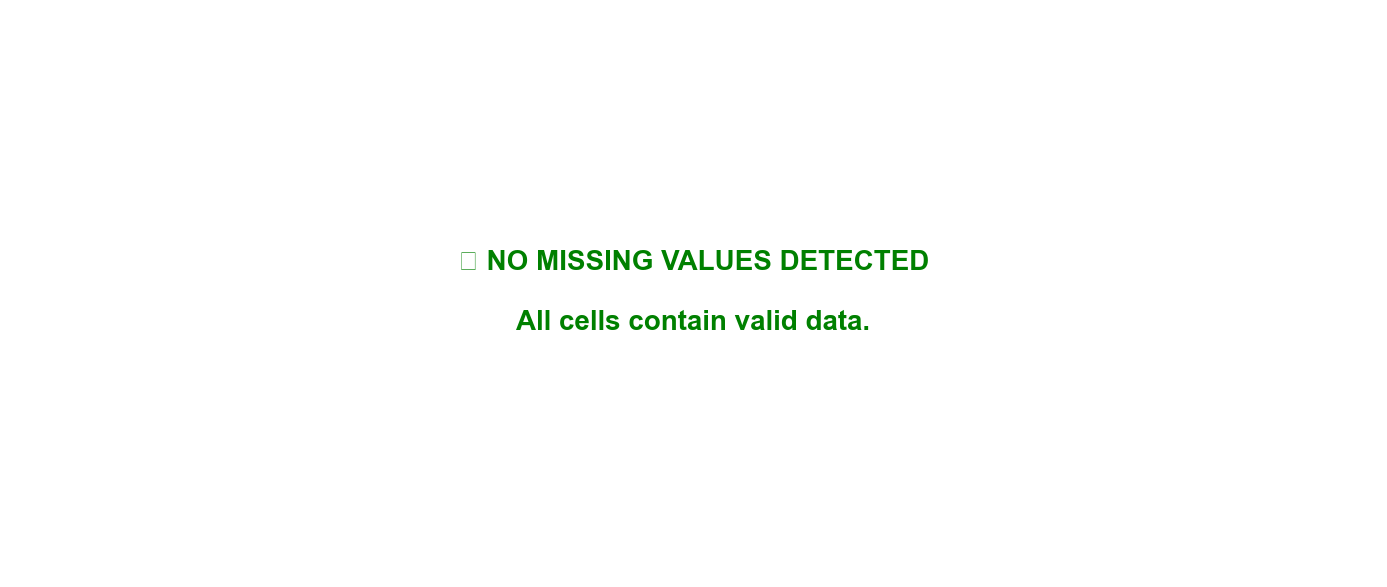


📸 Figure saved to: d:\antigravity project\WA_Fn-UseC_-Marketing-Customer-Value-Analysis.csv\CLV_IEEE_Project\report\figures\01_missing_value_analysis.png


In [33]:
# Visualize missing data pattern (if any)
fig, ax = plt.subplots(figsize=(14, 6))

# Create a heatmap of missing values
missing_matrix = df_raw.isnull().astype(int)

# Only show if there are missing values, otherwise show validation message
if missing_matrix.sum().sum() > 0:
    sns.heatmap(missing_matrix.T, cbar=True, yticklabels=True, cmap='YlOrRd', ax=ax)
    ax.set_title('Missing Value Heatmap (Yellow = Present, Red = Missing)', fontsize=14, fontweight='bold')
    ax.set_xlabel('Row Index')
    ax.set_ylabel('Columns')
else:
    ax.text(0.5, 0.5, '✅ NO MISSING VALUES DETECTED\n\nAll cells contain valid data.', 
            ha='center', va='center', fontsize=20, color='green', fontweight='bold',
            transform=ax.transAxes)
    ax.set_xlim(0, 1)
    ax.set_ylim(0, 1)
    ax.axis('off')

plt.tight_layout()
plt.savefig(os.path.join(FIGURES_DIR, '01_missing_value_analysis.png'), dpi=150, bbox_inches='tight')
plt.show()

print(f"\n📸 Figure saved to: {os.path.join(FIGURES_DIR, '01_missing_value_analysis.png')}")

### 6.2 Duplicate Record Detection

Duplicate records can artificially inflate counts and skew statistical measures. We check for:
1. **Exact duplicates**: All columns match
2. **Key duplicates**: Same customer ID but different records (which could be intentional)

In [34]:
# Duplicate detection
print("=" * 60)
print("DUPLICATE RECORD ANALYSIS")
print("=" * 60)

# Check for exact duplicates (all columns)
exact_duplicates = df_raw.duplicated().sum()
print(f"\n1. Exact Duplicates (all columns match): {exact_duplicates:,}")

if exact_duplicates > 0:
    print("   ⚠️ WARNING: Exact duplicates found!")
    print("   Sample duplicate rows:")
    print(df_raw[df_raw.duplicated(keep=False)].head(10))
else:
    print("   ✅ No exact duplicates detected.")

# Check for customer ID duplicates (if Customer column exists)
if 'Customer' in df_raw.columns:
    customer_duplicates = df_raw['Customer'].duplicated().sum()
    print(f"\n2. Customer ID Duplicates: {customer_duplicates:,}")
    
    if customer_duplicates > 0:
        print("   ⚠️ Some Customer IDs appear multiple times.")
        duplicate_customers = df_raw[df_raw['Customer'].duplicated(keep=False)]
        print(f"   Number of records with duplicate Customer IDs: {len(duplicate_customers):,}")
    else:
        print("   ✅ All Customer IDs are unique.")

DUPLICATE RECORD ANALYSIS

1. Exact Duplicates (all columns match): 0
   ✅ No exact duplicates detected.

2. Customer ID Duplicates: 0
   ✅ All Customer IDs are unique.


### 6.3 Data Type Validation

Sometimes data is loaded with incorrect types. For example:
- Dates might be read as strings
- Numeric codes might be read as integers when they should be categorical
- Currency values might have formatting issues

In [35]:
# Data type validation
print("=" * 60)
print("DATA TYPE VALIDATION")
print("=" * 60)

# Expected types based on column names
expected_types = {
    'Customer': 'identifier',
    'State': 'categorical',
    'Customer Lifetime Value': 'numeric',
    'Response': 'categorical',
    'Coverage': 'categorical',
    'Education': 'categorical',
    'Effective To Date': 'date',
    'EmploymentStatus': 'categorical',
    'Gender': 'categorical',
    'Income': 'numeric',
    'Location Code': 'categorical',
    'Marital Status': 'categorical',
    'Monthly Premium Auto': 'numeric',
    'Months Since Last Claim': 'numeric',
    'Months Since Policy Inception': 'numeric',
    'Number of Open Complaints': 'numeric',
    'Number of Policies': 'numeric',
    'Policy Type': 'categorical',
    'Policy': 'categorical',
    'Renew Offer Type': 'categorical',
    'Sales Channel': 'categorical',
    'Total Claim Amount': 'numeric',
    'Vehicle Class': 'categorical',
    'Vehicle Size': 'categorical'
}

# Check actual vs expected
validation_results = []
for col in df_raw.columns:
    actual_type = str(df_raw[col].dtype)
    expected = expected_types.get(col, 'unknown')
    
    # Determine if type is appropriate
    if expected == 'numeric' and 'float' in actual_type or 'int' in actual_type:
        status = '✅'
    elif expected == 'categorical' and actual_type == 'object':
        status = '✅'
    elif expected == 'date' and actual_type == 'object':  # Will need conversion
        status = '⚠️ (needs conversion)'
    elif expected == 'identifier' and actual_type == 'object':
        status = '✅'
    else:
        status = '🔍 (review)'
    
    validation_results.append({
        'Column': col,
        'Current Type': actual_type,
        'Expected': expected,
        'Status': status
    })

pd.DataFrame(validation_results)

DATA TYPE VALIDATION


,Column,Current Type,Expected,Status
0,Customer,object,identifier,✅
1,State,object,categorical,✅
2,Customer Lifetime Value,float64,numeric,✅
3,Response,object,categorical,✅
4,Coverage,object,categorical,✅
5,Education,object,categorical,✅
6,Effective To Date,object,date,⚠️ (needs conversion)
7,EmploymentStatus,object,categorical,✅
8,Gender,object,categorical,✅
9,Income,int64,numeric,✅


---

## 7. Data Cleaning Pipeline

Based on our quality assessment, we now implement a **systematic cleaning pipeline**. Each transformation is documented and reversible.

### 7.1 Create Backup

Before making any changes, we save a backup of the raw data. This is a **safety measure** that allows us to always return to the original state.

In [36]:
# Create working copy and backup
df = df_raw.copy()  # Working copy - we'll modify this

# Save backup of raw data
df_raw.to_csv(BACKUP_PATH, index=False)
print(f"✅ Raw data backup saved to: {BACKUP_PATH}")
print(f"   Backup size: {os.path.getsize(BACKUP_PATH) / 1024:.2f} KB")

✅ Raw data backup saved to: d:\antigravity project\WA_Fn-UseC_-Marketing-Customer-Value-Analysis.csv\CLV_IEEE_Project\data\processed\raw_backup.csv
   Backup size: 1546.03 KB


### 7.2 Column Name Standardization

We standardize column names to:
- Use lowercase (prevents case-sensitivity issues)
- Replace spaces with underscores (enables dot notation access)
- Remove special characters

In [37]:
# Standardize column names
print("=" * 60)
print("COLUMN NAME STANDARDIZATION")
print("=" * 60)

# Store original names for reference
original_columns = df.columns.tolist()

# Standardization function
def standardize_column_name(name):
    """Convert column name to lowercase with underscores."""
    return name.lower().replace(' ', '_').replace('-', '_')

# Apply standardization
df.columns = [standardize_column_name(col) for col in df.columns]

# Show the mapping
column_mapping = pd.DataFrame({
    'Original': original_columns,
    'Standardized': df.columns.tolist()
})

print("\n✅ Column names standardized:")
column_mapping

COLUMN NAME STANDARDIZATION

✅ Column names standardized:


,Original,Standardized
0,Customer,customer
1,State,state
2,Customer Lifetime Value,customer_lifetime_value
3,Response,response
4,Coverage,coverage
5,Education,education
6,Effective To Date,effective_to_date
7,EmploymentStatus,employmentstatus
8,Gender,gender
9,Income,income


### 7.3 String Normalization

Categorical text columns often contain inconsistencies like:
- Leading/trailing whitespace
- Mixed case ("California" vs "california" vs "CALIFORNIA")
- Extra internal spaces

We normalize all string columns to **lowercase with trimmed whitespace**.

In [38]:
# String normalization
print("=" * 60)
print("STRING NORMALIZATION")
print("=" * 60)

# Identify string columns (exclude the customer ID which should preserve original format)
string_columns = df.select_dtypes(include=['object']).columns.tolist()
columns_to_normalize = [col for col in string_columns if col != 'customer']

print(f"\nNormalizing {len(columns_to_normalize)} string columns:")

for col in columns_to_normalize:
    original_unique = df[col].nunique()
    
    # Apply normalization: strip whitespace and convert to lowercase
    df[col] = df[col].astype(str).str.strip().str.lower()
    
    new_unique = df[col].nunique()
    
    # Report if normalization reduced unique values (indicating inconsistencies were fixed)
    if new_unique < original_unique:
        print(f"   📋 {col}: {original_unique} → {new_unique} unique values (fixed {original_unique - new_unique} inconsistencies)")
    else:
        print(f"   ✅ {col}: {new_unique} unique values (no inconsistencies)")

STRING NORMALIZATION

Normalizing 15 string columns:
   ✅ state: 5 unique values (no inconsistencies)
   ✅ response: 2 unique values (no inconsistencies)
   ✅ coverage: 3 unique values (no inconsistencies)
   ✅ education: 5 unique values (no inconsistencies)
   ✅ effective_to_date: 59 unique values (no inconsistencies)
   ✅ employmentstatus: 5 unique values (no inconsistencies)
   ✅ gender: 2 unique values (no inconsistencies)
   ✅ location_code: 3 unique values (no inconsistencies)
   ✅ marital_status: 3 unique values (no inconsistencies)
   ✅ policy_type: 3 unique values (no inconsistencies)
   ✅ policy: 9 unique values (no inconsistencies)
   ✅ renew_offer_type: 4 unique values (no inconsistencies)
   ✅ sales_channel: 4 unique values (no inconsistencies)
   ✅ vehicle_class: 6 unique values (no inconsistencies)
   ✅ vehicle_size: 3 unique values (no inconsistencies)


### 7.4 Date Conversion

The `effective_to_date` column contains date information stored as strings. We convert it to proper datetime format for:
- Chronological sorting
- Date-based calculations
- Time-series analysis (if needed)

In [39]:
# Date conversion
print("=" * 60)
print("DATE CONVERSION")
print("=" * 60)

date_column = 'effective_to_date'

if date_column in df.columns:
    print(f"\nConverting '{date_column}' to datetime format...")
    print(f"   Sample original values: {df[date_column].head(3).tolist()}")
    
    # Convert to datetime (format: MM/DD/YY)
    df[date_column] = pd.to_datetime(df[date_column], format='%m/%d/%y', errors='coerce')
    
    # Check for conversion errors
    conversion_errors = df[date_column].isna().sum()
    
    if conversion_errors > 0:
        print(f"   ⚠️ Warning: {conversion_errors} values could not be converted")
    else:
        print(f"   ✅ All dates converted successfully")
    
    print(f"   New dtype: {df[date_column].dtype}")
    print(f"   Date range: {df[date_column].min()} to {df[date_column].max()}")
else:
    print(f"   Column '{date_column}' not found in dataset.")

DATE CONVERSION

Converting 'effective_to_date' to datetime format...
   Sample original values: ['2/24/11', '1/31/11', '2/19/11']
   ✅ All dates converted successfully
   New dtype: datetime64[ns]
   Date range: 2011-01-01 00:00:00 to 2011-02-28 00:00:00


### 7.5 Numeric Data Validation

We verify that numeric columns contain valid values and don't have impossible entries (e.g., negative income, negative claim amounts).

In [40]:
# Numeric validation
print("=" * 60)
print("NUMERIC DATA VALIDATION")
print("=" * 60)

numeric_columns = df.select_dtypes(include=['int64', 'float64']).columns.tolist()

# Columns that should not be negative
non_negative_cols = ['income', 'monthly_premium_auto', 'customer_lifetime_value', 
                      'total_claim_amount', 'number_of_policies', 'number_of_open_complaints',
                      'months_since_last_claim', 'months_since_policy_inception']

print("\nChecking for invalid negative values:")

for col in numeric_columns:
    if col in non_negative_cols:
        negative_count = (df[col] < 0).sum()
        
        if negative_count > 0:
            print(f"   ⚠️ {col}: {negative_count} negative values found!")
        else:
            print(f"   ✅ {col}: No invalid negative values")

NUMERIC DATA VALIDATION

Checking for invalid negative values:
   ✅ customer_lifetime_value: No invalid negative values
   ✅ income: No invalid negative values
   ✅ monthly_premium_auto: No invalid negative values
   ✅ months_since_last_claim: No invalid negative values
   ✅ months_since_policy_inception: No invalid negative values
   ✅ number_of_open_complaints: No invalid negative values
   ✅ number_of_policies: No invalid negative values
   ✅ total_claim_amount: No invalid negative values


---

## 8. Cleaned Data Summary

Let's review the final state of our cleaned dataset before saving it.

In [41]:
# Final summary
print("=" * 80)
print("CLEANED DATA SUMMARY")
print("=" * 80)

print(f"\n📊 Dataset Dimensions:")
print(f"   Rows:    {len(df):,}")
print(f"   Columns: {len(df.columns)}")

print(f"\n📋 Column Types:")
print(f"   Numeric:     {len(df.select_dtypes(include=['int64', 'float64']).columns)}")
print(f"   Categorical: {len(df.select_dtypes(include=['object']).columns)}")
print(f"   DateTime:    {len(df.select_dtypes(include=['datetime64']).columns)}")

print(f"\n✅ Data Quality Status:")
print(f"   Missing Values: {df.isnull().sum().sum()}")
print(f"   Duplicate Rows: {df.duplicated().sum()}")

print(f"\n💾 Memory Usage: {df.memory_usage(deep=True).sum() / (1024*1024):.2f} MB")

CLEANED DATA SUMMARY

📊 Dataset Dimensions:
   Rows:    9,134
   Columns: 24

📋 Column Types:
   Numeric:     8
   Categorical: 15
   DateTime:    1

✅ Data Quality Status:
   Missing Values: 0
   Duplicate Rows: 0

💾 Memory Usage: 9.04 MB


In [42]:
# Display final schema
print("=" * 80)
print("FINAL SCHEMA")
print("=" * 80)
df.info()

FINAL SCHEMA
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9134 entries, 0 to 9133
Data columns (total 24 columns):
 #   Column                         Non-Null Count  Dtype         
---  ------                         --------------  -----         
 0   customer                       9134 non-null   object        
 1   state                          9134 non-null   object        
 2   customer_lifetime_value        9134 non-null   float64       
 3   response                       9134 non-null   object        
 4   coverage                       9134 non-null   object        
 5   education                      9134 non-null   object        
 6   effective_to_date              9134 non-null   datetime64[ns]
 7   employmentstatus               9134 non-null   object        
 8   gender                         9134 non-null   object        
 9   income                         9134 non-null   int64         
 10  location_code                  9134 non-null   object        
 11  mari

In [43]:
# Preview cleaned data
print("=" * 80)
print("CLEANED DATA PREVIEW")
print("=" * 80)
df.head(10)

CLEANED DATA PREVIEW


,customer,state,customer_lifetime_value,response,coverage,education,effective_to_date,employmentstatus,gender,income,location_code,marital_status,monthly_premium_auto,months_since_last_claim,months_since_policy_inception,number_of_open_complaints,number_of_policies,policy_type,policy,renew_offer_type,sales_channel,total_claim_amount,vehicle_class,vehicle_size
0,BU79786,washington,2763.52,no,basic,bachelor,2011-02-24,employed,f,56274,suburban,married,69,32,5,0,1,corporate auto,corporate l3,offer1,agent,384.81,two-door car,medsize
1,QZ44356,arizona,6979.54,no,extended,bachelor,2011-01-31,unemployed,f,0,suburban,single,94,13,42,0,8,personal auto,personal l3,offer3,agent,1131.46,four-door car,medsize
2,AI49188,nevada,12887.43,no,premium,bachelor,2011-02-19,employed,f,48767,suburban,married,108,18,38,0,2,personal auto,personal l3,offer1,agent,566.47,two-door car,medsize
3,WW63253,california,7645.86,no,basic,bachelor,2011-01-20,unemployed,m,0,suburban,married,106,18,65,0,7,corporate auto,corporate l2,offer1,call center,529.88,suv,medsize
4,HB64268,washington,2813.69,no,basic,bachelor,2011-02-03,employed,m,43836,rural,single,73,12,44,0,1,personal auto,personal l1,offer1,agent,138.13,four-door car,medsize
5,OC83172,oregon,8256.30,yes,basic,bachelor,2011-01-25,employed,f,62902,rural,married,69,14,94,0,2,personal auto,personal l3,offer2,web,159.38,two-door car,medsize
6,XZ87318,oregon,5380.90,yes,basic,college,2011-02-24,employed,f,55350,suburban,married,67,0,13,0,9,corporate auto,corporate l3,offer1,agent,321.60,four-door car,medsize
7,CF85061,arizona,7216.10,no,premium,master,2011-01-18,unemployed,m,0,urban,single,101,0,68,0,4,corporate auto,corporate l3,offer1,agent,363.03,four-door car,medsize
8,DY87989,oregon,24127.50,yes,basic,bachelor,2011-01-26,medical leave,m,14072,suburban,divorced,71,13,3,0,2,corporate auto,corporate l3,offer1,agent,511.20,four-door car,medsize
9,BQ94931,oregon,7388.18,no,extended,college,2011-02-17,employed,f,28812,urban,married,93,17,7,0,8,special auto,special l2,offer2,branch,425.53,four-door car,medsize


---

## 9. Export Cleaned Data

We save the cleaned dataset for use in subsequent notebooks. This ensures consistency across the analysis pipeline.

In [44]:
# Export cleaned data
print("=" * 60)
print("EXPORTING CLEANED DATA")
print("=" * 60)

# Save to CSV
df.to_csv(CLEAN_DATA_PATH, index=False)

# Verify export
exported_size = os.path.getsize(CLEAN_DATA_PATH)

print(f"\n✅ Cleaned data exported successfully!")
print(f"   Location: {CLEAN_DATA_PATH}")
print(f"   File Size: {exported_size / 1024:.2f} KB ({exported_size / (1024*1024):.2f} MB)")

# Quick verification by re-reading
df_verify = pd.read_csv(CLEAN_DATA_PATH)
print(f"   Verification Read: {len(df_verify):,} rows × {len(df_verify.columns)} columns")

EXPORTING CLEANED DATA

✅ Cleaned data exported successfully!
   Location: d:\antigravity project\WA_Fn-UseC_-Marketing-Customer-Value-Analysis.csv\CLV_IEEE_Project\data\processed\cleaned_data.csv
   File Size: 1575.44 KB (1.54 MB)
   Verification Read: 9,134 rows × 24 columns


---

## 10. Notebook Summary and Next Steps

### What We Accomplished

In this notebook, we completed the foundational data preparation phase:

| Step | Description | Outcome |
|------|-------------|--------|
| 1 | Data Loading | 9,134 records loaded successfully |
| 2 | Schema Inspection | 24 columns identified and categorized |
| 3 | Missing Value Check | ✅ No missing values |
| 4 | Duplicate Detection | ✅ No exact duplicates |
| 5 | Column Standardization | All columns normalized to snake_case |
| 6 | String Normalization | Categorical values cleaned and lowercased |
| 7 | Date Conversion | Date column converted to datetime |
| 8 | Data Export | Clean dataset saved for downstream use |

### Key Findings

1. **Data Quality**: The raw dataset was remarkably clean—no missing values or duplicates
2. **Feature Set**: 24 features covering demographics, policy details, and behavioral data
3. **Target Variable**: Customer Lifetime Value is present and ready for prediction

### Next Steps

In **Notebook 02: Exploratory Data Analysis**, we will:
- Perform univariate analysis on all features
- Explore relationships between features and the target variable
- Identify patterns, trends, and potential outliers
- Generate visualizations to support our findings

---

**End of Notebook 01**